In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class FaceCompletionDataset(Dataset):
    def __init__(self, image_dir, mask_image_dir, mask_dir, block_size=(64, 64)):
        self.image_dir = image_dir
        self.mask_image_dir = mask_image_dir
        self.mask_dir = mask_dir
        self.block_size = block_size
        self.image_list = os.listdir(image_dir)[:10]
        self.mask_image_list = os.listdir(mask_image_dir)[:10]
        self.mask_list = os.listdir(mask_dir)[:10]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_image_path = os.path.join(self.mask_image_dir, self.mask_image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        masked_image = cv2.imread(mask_image_path)
        
        image = ToTensor()(image)
        mask = ToTensor()(mask)
        masked_image = ToTensor()(masked_image)

        return image, mask, masked_image

#     def random_block_mask(self, image):
#         h, w, _ = image.shape
#         x = np.random.randint(0, w - self.block_size[0])
#         y = np.random.randint(0, h - self.block_size[1])
#         masked_image = image.copy()
#         noise = np.random.randint(0, 256, size=(self.block_size[1], self.block_size[0], 3), dtype=np.uint8)
#         masked_image[y:y + self.block_size[1], x:x + self.block_size[0]] = noise
#         return masked_image

image_dir = "preprocessed_images/"
masked_image_dir = "masked_images/"
masks_dir = "masks/"

celeba_dataset = FaceCompletionDataset(image_dir, masked_image_dir, masks_dir)



In [2]:
from torch.utils.data import DataLoader, random_split

# Assuming your_dataset is an instance of your Dataset class
train_size = int(0.8 * len(celeba_dataset))  # Use 80% of the dataset for training
val_size = len(celeba_dataset) - train_size

train_dataset, val_dataset = random_split(celeba_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import torch
import torchvision.models as models
vgg19 = models.vgg19()
model_weights_path = 'vgg19-dcbb9e9d.pth'
vgg19.load_state_dict(torch.load(model_weights_path))
vgg19 = vgg19.to(device)
vgg19.eval()
 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np
import torch
import torch.nn as nn
import torch.nn as nn
import torchvision.models as models

class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super(Generator, self).__init__()

        vgg19 = models.vgg19()
        model_weights_path = 'vgg19-dcbb9e9d.pth'
        vgg19.load_state_dict(torch.load(model_weights_path))
        vgg19 = vgg19.to(device)
        vgg19.eval()

        self.encoder = nn.Sequential(
            *list(vgg19.features.children())[:18],  # conv1 to pool3 of VGG-19
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(4 * 8 * 8 * 256, 4096),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(4096, 8 * 8 * 256),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, in_channels, kernel_size=5, stride=1, padding=2)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return torch.sigmoid(x2)

## refer from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/pix2pix/models.py
# However, in the context of image inpainting, we usually have one input, which is the generated/completed image, or the real image for comparison. 
# so i modify the discriminator to accept a single input and process it accordingly. 
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True, stride=2):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=stride, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=False))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512, stride=1),  # Change stride to 1
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img):
        return self.model(img)


In [6]:
import torchvision.models as models
import torchvision.transforms as transforms
generator = Generator()

discriminator_global = Discriminator(in_channels=3)
discriminator_local = Discriminator(in_channels=3)

criterion = nn.BCELoss()
criterion_adv = nn.BCEWithLogitsLoss()
criterion_context = nn.L1Loss()

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_discriminator_global = torch.optim.Adam(discriminator_global.parameters(), lr=0.0002)
optimizer_discriminator_local = torch.optim.Adam(discriminator_local.parameters(), lr=0.0002)
criterion_perceptual = nn.L1Loss()


In [7]:
generator = generator.to(device)
discriminator_global = discriminator_global.to(device)
discriminator_local = discriminator_local.to(device)

In [8]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def evaluate_models(generator, discriminator_global, discriminator_local, dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg19):
    generator.eval()
    discriminator_global.eval()
    discriminator_local.eval()

    total_gen_loss = 0
    total_disc_global_loss = 0
    total_disc_local_loss = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, masks, masked_images) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            masked_images = masked_images.to(device) 

            completed_images = generator(masked_images)

            real_labels = torch.ones(images.size(0), 1).to(device)
            fake_labels = torch.zeros(images.size(0), 1).to(device)

            local_real_output = discriminator_local(images)
            local_fake_output = discriminator_local(completed_images)

            global_real_output = discriminator_global(images)
            global_fake_output = discriminator_global(completed_images)

            # Expand the real and fake labels to match the output size of the discriminators
            real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output).clone()
            fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output).clone()

            real_labels_expanded = real_labels_expanded.to(device)
            fake_labels_expanded = fake_labels_expanded.to(device)
            
            loss_adv_global = criterion_adv(global_real_output, real_labels_expanded) + criterion_adv(global_fake_output, fake_labels_expanded)
            loss_adv_local = criterion_adv(local_real_output, real_labels_expanded) + criterion_adv(local_fake_output, fake_labels_expanded)
            loss_adv = loss_adv_global + loss_adv_local

            expanded_masks = masks.expand_as(images)
            loss_context = criterion_context(completed_images * expanded_masks, images * expanded_masks)
 
            loss_perceptual = criterion_perceptual(vgg19(completed_images), vgg19(images))

            loss_generator = loss_adv + loss_context + loss_perceptual

            total_gen_loss += loss_generator.item()
            total_disc_global_loss += loss_adv_global.item()
            total_disc_local_loss += loss_adv_local.item()
            total_samples += images.size(0)

    mean_gen_loss = total_gen_loss / total_samples
    mean_disc_global_loss = total_disc_global_loss / total_samples
    mean_disc_local_loss = total_disc_local_loss / total_samples

    return mean_gen_loss, mean_disc_global_loss, mean_disc_local_loss

def evaluate_model_external(model, dataloader):
    model.eval()
    total_psnr = 0
    total_ssim = 0
    total_samples = 0

    with torch.no_grad():
        for i, (images, masks, masked_images) in enumerate(dataloader):
            masked_images = masked_images.to(device) 
            completed_images = model(masked_images)
 
            for i in range(images.size(0)):
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                completed_image = completed_images[i].cpu().numpy().transpose(1, 2, 0)

                total_psnr += psnr(image, completed_image)
                total_ssim += ssim(image, completed_image, multichannel=True, win_size=3, data_range=1)

            total_samples += images.size(0)

    return total_psnr / total_samples, total_ssim / total_samples



In [11]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)
save_path = './model/'

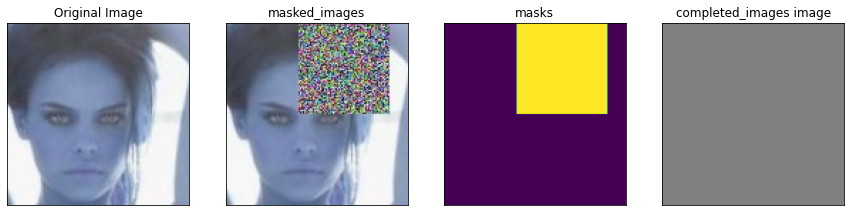

Epoch: 0, Validation Losses - Generator: 2.0424, Discriminator Global: 0.4188, Discriminator Local: 0.4301
Epoch: 0, Validation PSNR: 10.9678, SSIM: 0.0918


/tmp/ipykernel_52160/519455267.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df.append({'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}, ignore_index=True)


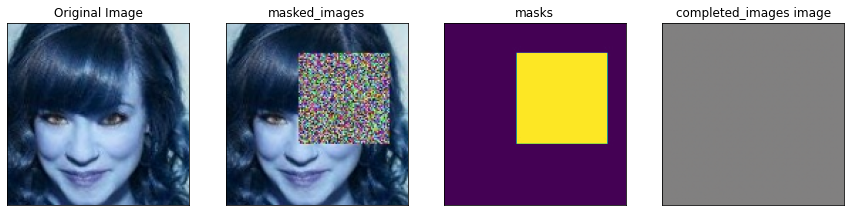

Epoch: 1, Validation Losses - Generator: 1.8916, Discriminator Global: 0.3532, Discriminator Local: 0.3652
Epoch: 1, Validation PSNR: 10.9546, SSIM: 0.0918


/tmp/ipykernel_52160/519455267.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df.append({'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}, ignore_index=True)


In [12]:
num_epochs = 2
best_loss = float('inf')
patience = 3
result_df = pd.DataFrame(columns= ['epoch', 'step', 'val_gen_loss', 'val_disc_global_loss', 'val_disc_local_loss', 'val_psnr', 'val_ssim' ])
for epoch in range(num_epochs):
    for i, (images, masks, masked_images) in enumerate(train_dataloader):
        # Resize the images and masks to a consistent size
        
        images = images.to(device)
        masked_images = masked_images.to(device)
        masks = masks.to(device)
        # Train the generator and discriminators using the images and masks
        # Implement the training algorithm according to the paper
    
        # 1. Generate completed images using the generator (Completion Network)

        completed_images = generator(masked_images)
 
        # 2. Compute the adversarial loss for the generator using the global and local discriminators
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
 
        local_real_output = discriminator_local(images)
        local_fake_output = discriminator_local(completed_images)

        global_real_output = discriminator_global(images)
        global_fake_output = discriminator_global(completed_images)

        
        # Expand the real and fake labels to match the output size of the discriminators
        real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output).clone()
        fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output).clone()
        
        real_labels_expanded = real_labels_expanded.to(device)
        fake_labels_expanded = fake_labels_expanded.to(device)
        
        loss_adv_global = criterion_adv(global_real_output, real_labels_expanded) + criterion_adv(global_fake_output, fake_labels_expanded)
        loss_adv_local = criterion_adv(local_real_output, real_labels_expanded) + criterion_adv(local_fake_output, fake_labels_expanded)
        loss_adv = loss_adv_global + loss_adv_local
        
        # 3. Compute the contextual loss by measuring the L1 distance between the original and completed images
        expanded_masks = masks.expand_as(images)
        loss_context = criterion_context(completed_images * expanded_masks, images * expanded_masks)

        # 4. Compute the perceptual loss using the VGG-16 network
        # Resize completed_images and images to be compatible with VGG-16
#         vgg_completed_images = upsample_for_vgg(completed_images)
#         vgg_images = upsample_for_vgg(images)

        loss_perceptual = criterion_perceptual(vgg19(completed_images), vgg19(images))

        # 5. Update the weights of the generator using the combined loss (adversarial, contextual, and perceptual losses)
        loss_generator = loss_adv + loss_context + loss_perceptual
        optimizer_generator.zero_grad()
        loss_generator.backward(retain_graph=True)
        optimizer_generator.step()

        # 6. Update the weights of the global and local discriminators using their respective adversarial losses
        optimizer_discriminator_global.zero_grad()
        loss_adv_global.backward(retain_graph=True)

        optimizer_discriminator_local.zero_grad()
        loss_adv_local.backward()

        optimizer_discriminator_global.step()
        optimizer_discriminator_local.step()
        if i % 4000 == 0:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            axs[0].imshow(return_image_numpy(images))
            axs[0].set_title("Original Image")
            axs[1].imshow(return_image_numpy(masked_images))
            axs[1].set_title("masked_images")
            axs[2].imshow(return_image_numpy(masks))
            axs[2].set_title("masks")
            axs[3].imshow(return_image_numpy(completed_images))
            axs[3].set_title("completed_images image")

            for ax in axs:
                ax.set_xticks([])
                ax.set_yticks([])

    plt.show()
    
    # Evaluation
    # Inside your training loop, after each epoch
    val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg19)
    print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.4f}, Discriminator Global: {val_disc_global_loss:.4f}, Discriminator Local: {val_disc_local_loss:.4f}")
    val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader)
    print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")
    result_df.append({'epoch': epoch, 'step': i, 'val_gen_loss': val_gen_loss, 'val_disc_global_loss': val_disc_global_loss, 'val_disc_local_loss': val_disc_local_loss, 'val_psnr': val_psnr, 'val_ssim': val_ssim}, ignore_index=True)
     
    # Update the best loss and save the model if necessary
    
    if val_gen_loss < best_loss:
        best_loss = val_gen_loss
        best_generator = copy.deepcopy(generator.state_dict())
        best_discriminator_global = copy.deepcopy(discriminator_global.state_dict())
        best_discriminator_local = copy.deepcopy(discriminator_local.state_dict())
        # Save the best models
        torch.save(best_generator, os.path.join(save_path, 'generator.pth'))
        torch.save(best_discriminator_global, os.path.join(save_path, 'discriminator_global.pth'))
        torch.save(best_discriminator_local, os.path.join(save_path, 'discriminator_local.pth'))

        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break


In [13]:
result_df.to_csv('result_df.csv')

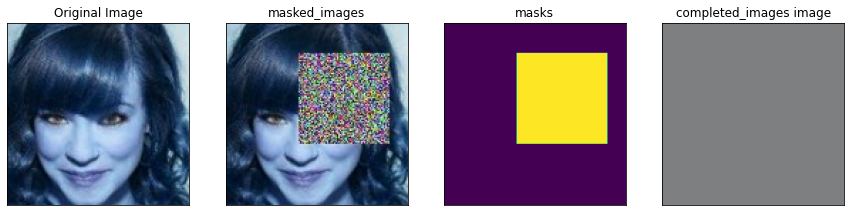

In [57]:
import cv2
import matplotlib.pyplot as plt
# Display the original image, mask, and masked image
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(return_image_numpy(images))
axs[0].set_title("Original Image")
axs[1].imshow(return_image_numpy(masked_images))
axs[1].set_title("masked_images")
axs[2].imshow(return_image_numpy(masks))
axs[2].set_title("masks")
axs[3].imshow(return_image_numpy(completed_images))
axs[3].set_title("completed_images image")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])


#images, masks, masked_images